In [6]:
using LinearSolve, LinearAlgebra
using Plots, LinearOperators, LinearMaps
using IterativeSolvers
using DelimitedFiles


### structs

#### node struct

In [7]:
mutable struct Node
    id::Int
    j::Int
    i::Int
    x::Float64
    y::Float64
    h::Float64
    coarse::Bool
end

#### mesh struct

In [8]:
mutable struct Mesh
    N::Int
    h::Float64
    num_nodes::Int
    dofs::Vector{Node}
    coarse_data::Array{Float64,2}
    fine_data::Array{Float64,2}
    coarse_x::Vector{Float64}
    coarse_y::Vector{Float64}
    fine_x::Vector{Float64}
    fine_y::Vector{Float64}

    function Mesh(N)
        h = 0.5/N
        dofs = Vector{Node}()
        
        coarse_x = LinRange(h,0.5,N)
        coarse_y = LinRange(0,1-h,2*N)
        
        fine_x = LinRange(0.5+h/2,1-h/2,2*N-1)
        fine_y = LinRange(0,1-h/2,4*N)
        
        id = 0
        for (i,y) in enumerate(coarse_y)
            for (j,x) in enumerate(coarse_x)
                node = Node(id,j,i,x,y,h,true)
                push!(dofs,node)
                id += 1
            end
        end

        for (i,y) in enumerate(fine_y)
            for (j,x) in enumerate(fine_x)
                node = Node(id,j,i,x,y,h/2,false)
                push!(dofs,node)
                id += 1
            end
        end

        coarse_array = Array{Float64,2}(undef,2*N,N)
        fine_array = Array{Float64,2}(undef,4*N,2*N-1)
        
        new(N,h,id,dofs,coarse_array,fine_array,coarse_x,coarse_y,fine_x,fine_y)
    end
end

#### helpers

In [9]:
function view(mesh)
    x_vals_0 = Vector{Float64}()
    x_vals_1 = Vector{Float64}()
    y_vals_0 = Vector{Float64}()
    y_vals_1 = Vector{Float64}()
    
    h = 0
    for dof in mesh.dofs
        if dof.coarse
            h = dof.h
            push!(x_vals_0,dof.x)
            push!(y_vals_0,dof.y)
        else
            push!(x_vals_1,dof.x)
            push!(y_vals_1,dof.y)
        end
    end
    
    plot(x_vals_1,y_vals_1,seriestype=:scatter,label="fine",xlims=(0,1),ylims=(-h,1))
    plot!(x_vals_0,y_vals_0,seriestype=:scatter,label="coarse")
end
;

In [10]:
function Print(args)
    for a in args
        print(a,"   \t")
    end
    print("\n")
end

Print (generic function with 1 method)

In [12]:
function norm(U,u,Ltype::String)
    #Ltype = "inf"
    vec = broadcast(abs,U-u)
    return maximum(vec)
end

function norm(U,u,Ltype::Int)
    # Ltype = 1
    vec = broadcast(abs,U-u)
    return sum(vec)/size(vec)[1]
end

function norm(U,u,mesh)
    vec = broadcast(abs,U-u)
    v_coarse, v_fine = split_data(vec,mesh)
    coarse_integral = sum(v_coarse)*mesh.h^2
    fine_integral = sum(v_fine)*mesh.h^2/4
    interface_integral = sum(v_fine[:,1])*mesh.h^2/8
    return coarse_integral+fine_integral+interface_integral
end

norm (generic function with 3 methods)

### solver code

#### fd code

In [13]:
function fd181(data)
    
    differenced = -8*copy(data)

    differenced += circshift(data, (1,0))
    differenced += circshift(data, (-1,0))

    differenced[1:end,2:end] += data[1:end,1:end-1]
    differenced[1:end,1:end-1] += data[1:end,2:end]

    differenced[1:end,2:end] += circshift(data[1:end,1:end-1], (1,0))
    differenced[1:end,1:end-1] += circshift(data[1:end,2:end],( 1,0))

    differenced[1:end,2:end] += circshift(data[1:end,1:end-1], (-1,0))
    differenced[1:end,1:end-1] += circshift(data[1:end,2:end],( -1,0))


    return differenced/3
end



function finite_difference(data,mesh)
    c_data, f_data = split_data(data,mesh)

    c_data_diff = fd181(c_data)
    f_data_diff = fd181(f_data)

    data_diffs = [c_data_diff, f_data_diff]

    # not periodic in x
    c_data_diff[:,end] += -1/3*(c_data[:,end]+circshift(c_data[:,end],(1))+circshift(c_data[:,end],(-1)))+ 2/3*f_data[1:2:end,1]
    c_data_diff[:,end] += 1/2*(circshift(f_data[:,1],(1))[1:2:end]+circshift(f_data[:,1],(-1))[1:2:end])
    c_data_diff[:,end] += 1/6*(circshift(f_data[:,1],(2))[1:2:end]+circshift(f_data[:,1],(-2))[1:2:end])


    f_data_diff[1:2:end,1] += 2/3*c_data[:,end] + 1/6*(circshift(c_data[:,end],(1))+circshift(c_data[:,end],(-1)))
    f_data_diff[2:2:end,1] += 1/2*(c_data[:,end]+circshift(c_data[:,end],(-1)))
    
    # # fully periodic
    # flim, clim = [length(f_data[1,:]), 1], [1, length(c_data[1,:])]

    # for i in range(1,2)

    #     c_data_diff[:,clim[i]] += c_data[:,clim[i]] - circshift(c_data[:,clim[i]],(1)) - circshift(c_data[:,clim[i]],(-1))+ 2/3*f_data[1:2:end,flim[i]]
    #     c_data_diff[:,clim[i]] += 1/2*(circshift(f_data[:,flim[i]],(1))[1:2:end]+circshift(f_data[:,flim[i]],(-1))[1:2:end])
    #     c_data_diff[:,clim[i]] += 1/6*(circshift(f_data[:,flim[i]],(2))[1:2:end]+circshift(f_data[:,flim[i]],(-2))[1:2:end])


    #     f_data_diff[1:2:end,flim[i]] += 2/3*c_data[:,clim[i]] + 1/6*(circshift(c_data[:,clim[i]],(1))+circshift(c_data[:,clim[i]],(-1)))
    #     f_data_diff[2:2:end,flim[i]] += 1/2*(c_data[:,clim[i]]+circshift(c_data[:,clim[i]],(-1)))
    # end
    
    data_diff = recombine(c_data_diff, f_data_diff)

    return -data_diff
end

finite_difference (generic function with 1 method)

#### split and recombine

In [14]:
function split_data(data, mesh)
    yc, xc = size(mesh.coarse_data)
    yf, xf = size(mesh.fine_data)

    c_data = reshape(data[1:xc*yc],(xc,yc))
    f_data = reshape(data[xc*yc+1:end],(xf,yf))
    return c_data', f_data'
end


function recombine(coarse_array,fine_array)
    t0, t1 = size(coarse_array)
    t2, t3 = size(fine_array)
    full_size = t0*t1 + t2*t3

    full = Array{Float64,1}(undef,full_size)
    full[1:t0*t1] = reduce(vcat,coarse_array')
    full[t0*t1+1:end] = reduce(vcat,fine_array')
    return full
end

recombine (generic function with 1 method)

#### rhs code

In [15]:
function compute_gauss_force_vals(m::Mesh,f)
    lg,rg = m.h/2*(-1/sqrt(3)+1), m.h/2*(1/sqrt(3)+1)
    coarse_x = LinRange(0,0.5-m.h,m.N)
    coarse_y = LinRange(0,1-m.h,2*m.N)
    coarse_g = Array{Float64,3}(undef,2*m.N,m.N,4)
    for (i,y) in enumerate(coarse_y)
        for (j,x) in enumerate(coarse_x)
            coarse_g[i,j,:] = [f(lg+x,lg+y),f(rg+x,lg+y),f(lg+x,rg+y),f(rg+x,rg+y)]
        end
    end

    lg/=2; rg/=2;
    fine_x = LinRange(0.5,1-m.h/2,2*m.N)
    fine_y = LinRange(0,1-m.h/2,4*m.N)
    fine_g = Array{Float64,3}(undef,4*m.N,2*m.N,4)
    for (i,y) in enumerate(fine_y)
        for (j,x) in enumerate(fine_x)
            fine_g[i,j,:] = [f(lg+x,lg+y), f(rg+x,lg+y), f(lg+x,rg+y), f(rg+x,rg+y)]
        end
    end

    return coarse_g,fine_g
end

function compute_gauss_shape_vals()
    phiL(xi) = 1/2+1/2*xi
    phiR(xi) = 1/2-1/2*xi
    phis = [phiL,phiR]
    ps = [-1/sqrt(3),1/sqrt(3)]

    phi_g = Array{Float64,3}(undef,2,2,4)
    for (yind,phii) in enumerate(phis)
        for (xind,phij) in enumerate(phis)
            index = 1
            print('\n')
            for yi in ps
                for xj in ps 
                    phi_g[yind,xind,index] = phii(yi)*phij(xj)
                    index += 1
                end
            end
        end
    end

    return phi_g
end

compute_gauss_shape_vals (generic function with 1 method)

In [16]:
function compute_full_force(m::Mesh,gc,gf,phig)
    intc = Array{Float64,2}(undef,2*m.N+1,m.N+1)
    for yind in range(1,2*m.N+1)
        for xind in range(1,m.N+1)
            ys, xs = 1+(yind==1),1+(xind==1)
            ye, xe = 2-(yind==2*m.N+1),2-(xind==m.N+1)
            fys, fxs = max(1,yind-1), max(1,xind-1)
            fye, fxe = min(yind,2*m.N), min(xind,m.N)
            intc[yind,xind] = sum(gc[fys:fye,fxs:fxe,:].*phig[ys:ye,xs:xe,:])*m.h^2/4
        end
    end

    intf = Array{Float64,2}(undef,4*m.N+1,2*m.N+1)
    for yind in range(1,4*m.N+1)
        for xind in range(1,2*m.N+1)
            ys, xs = 1+(yind==1),1+(xind==1)
            ye, xe = 2-(yind==4*m.N+1),2-(xind==2*m.N+1)
            fys, fxs = max(1,yind-1), max(1,xind-1)
            fye, fxe = min(yind,4*m.N), min(xind,2*m.N)
            intf[yind,xind] = sum(gf[fys:fye,fxs:fxe,:].*phig[ys:ye,xs:xe,:])*m.h^2/16
        end
    end
    return intc, intf
end

function condense_force(intc, intf)
    compact_coarse = intc[1:end-1,2:end]
    compact_fine = intf[1:end-1,2:end-1]

    tmp = intf[1:end-1,1]
    compact_coarse[:,end] += tmp[1:2:end] + 1/2*(circshift(tmp,(1))[1:2:end]+circshift(tmp,(-1))[1:2:end])
    compact_coarse[1,:] += intc[end,2:end]
    compact_fine[1,:] += intf[end,2:end-1]
    compact_coarse[1,end] += intf[end,1]
    return compact_coarse, compact_fine
end

condense_force (generic function with 1 method)

In [ ]:
function apply_func_to_mesh(func,mesh,combine::Bool=false)
    c_func = copy(mesh.coarse_data)
    f_func = copy(mesh.fine_data)

    for (i,y) in enumerate(mesh.coarse_y)
        for (j,x) in enumerate(mesh.coarse_x)
            c_func[i,j] = func(x,y)
        end
    end

    for (i,y) in enumerate(mesh.fine_y)
        for (j,x) in enumerate(mesh.fine_x)
            f_func[i,j] = func(x,y)
        end
    end
    if combine
        return recombine(c_func,f_func)
    end
    return c_func,f_func
end

function get_force_vector(mesh::Mesh,force_func,combine::Bool=false)
    gc,gf = compute_gauss_force_vals(mesh,force_func);
    phig = compute_gauss_shape_vals();

    tmp_C, tmp_F = compute_full_force(mesh,gc,gf,phig)
    c_F, f_F = condense_force(tmp_C,tmp_F)

    if combine
        return recombine(c_F,f_F)
    end
    #return tmp_C[1:end-1,2:end], tmp_F[1:end-1,2:end-1],c_F,f_F
    return c_F,f_F
end


function build_rhs(mesh,ufunc,ffunc)
    # populate forcing vector
    c_force,f_force = get_force_vector(mesh,ffunc)
    
    # dirichlet bc
    for (i,y) in enumerate(mesh.coarse_y)
        c_force[i,1] -= ufunc(0,y)/3
        if i == 1
            c_force[end,1] -= ufunc(0,y)/3
        else
            c_force[i-1,1] -= ufunc(0,y)/3
        end
        if i == length(c_force[:,1])
            c_force[1,1] -= ufunc(0,y)/3
        else
            c_force[i+1,1] -= ufunc(0,y)/3
        end
    end
    for (i,y) in enumerate(mesh.fine_y)
        f_force[i,end] -= ufunc(1,y)/3
        if i == 1
            f_force[end,end] -= ufunc(1,y)/3
        else
            f_force[i-1,end] -= ufunc(1,y)/3
        end
        if i == length(f_force[:,1])
            f_force[1,end] -= ufunc(1,y)/3
        else
            f_force[i+1,end] -= ufunc(1,y)/3
        end
    end

    force_vector = recombine(c_force, f_force)
    return -force_vector
end

build_rhs (generic function with 1 method)

#### scratch

In [18]:
m = Mesh(2);

In [30]:
laplace(X) = finite_difference(X,m);

sys_size = m.num_nodes
L = LinearMap(X->laplace(X), sys_size, sys_size)

ufunc(x,y) = sin(2*pi*x)#+cos(2*pi*y)
ffunc(x,y) = -4*pi^2*(sin(2*pi*x))#+cos(2*pi*y))
F = build_rhs(m, ufunc, ffunc)

sol = cg(L,F,reltol=1e-8);

In [31]:
Lmat = Matrix(L);

In [32]:
py_L = readdlm("check_lmat.txt");
py_F = readdlm("check_fvec.txt");
py_U = readdlm("check_uvec.txt");

In [33]:
for i in range(1,32)
    for j in range(1,32)
        if abs(Lmat[i,j]-py_L[i,j])>1e-15
            print("AH")
        end
    end
    if abs(py_F[i]-F[i])>1e-15
        print("EEK")
    end
    if abs(py_U[i]-sol[i])>1e-13
        print(i," ")
    end
end

#### solver

In [37]:
function solve(N,ufunc,ffunc)
    mesh = Mesh(N)
    
    sys_size = mesh.num_nodes
    laplace(X) = finite_difference(X,mesh)
    L = LinearMap(X->laplace(X), sys_size, sys_size, issymmetric=true, ishermitian=true, isposdef=true)
    F = build_rhs(mesh, ufunc, ffunc)
    
    sol = cg(L,F,reltol=1e-8)

    return sol, L, F, mesh
end

;

In [38]:
function convergence(ufunc,ffunc,steps)
    norms = zeros(4,steps)
    trunc_norms = zeros(4,steps)
    Print(["N","Linf Norm\t","L1 Norm\t\t","L2 Norm\t\t"])

    for step in range(1,steps)
        N = 2^step
        U, L, F, m = solve(N,ufunc, ffunc)
        u = apply_func_to_mesh(ufunc,m,true)
        norms[1,step] = N
        norms[2,step] = norm(U,u,"inf")
        norms[3,step] = norm(U,u,1)
        norms[4,step] = norm(U,u,m)
        Print(norms[:,step])

        # Lu = L(u)
        # trunc_norms[1,step] = N
        # trunc_norms[2,step] = norm(F,Lu,"inf")
        # trunc_norms[3,step] = norm(F,Lu,1)
        # trunc_norms[4,step] = norm(F,Lu,m)
        # Print(trunc_norms[:,step])
    end

    #l = @layout [a b]
    p1 = plot(norms[1,:],norms[2,:],label="Linf", xaxis=:log, yaxis=:log)
    p1 = plot!(norms[1,:],norms[3,:],label="L1")
    p1 = plot!(norms[1,:],norms[4,:],label="L2")
    p1 = plot!(norms[1,:],norms[1,:].^(-2),label="1/N^2")
    # p1 = plot!(norms[1,:],norms[1,:].^(-1),label="1/N")

    # p2 = plot(trunc_norms[1,2:end],trunc_norms[2,2:end],label="Linf", xaxis=:log, yaxis=:log)
    # p2 = plot(trunc_norms[1,2:end],trunc_norms[3,2:end],label="L1", xaxis=:log, yaxis=:log, plot_title="Truncation Error")
    # p2 = plot!(trunc_norms[1,2:end],trunc_norms[4,2:end],label="L2", xaxis=:log, yaxis=:log)
    # p2 = plot!(trunc_norms[1,2:end],trunc_norms[1,2:end].^(-2),label="1/N^2", xaxis=:log, yaxis=:log)

    plot(p1)#,p2,layout = l)

end

function convergence(ufunc,ffunc)
    convergence(ufunc,ffunc,5)
end

convergence (generic function with 2 methods)

### solve

#### horizontal refinement

N   	Linf Norm	   	L1 Norm		   	L2 Norm		   	




2.0   	0.053879127079747735   	0.014830057919212943   	0.015414885695238145   	




4.0   	0.018478682642502298   	0.0038210354124908843   	0.0040345410487481435   	




8.0   	0.005218351652396258   	0.0009356717650485438   	0.0009722052607126028   	




16.0   	0.001377023469446348   	0.0002295127918610955   	0.00023470532754795651   	


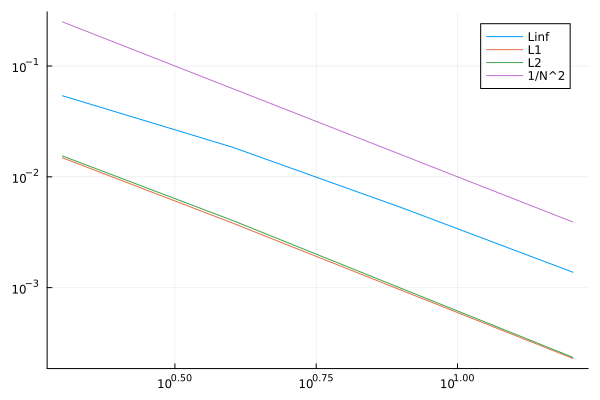

In [39]:
ufunc(x,y) = sin(2*pi*x)+cos(2*pi*y)
ffunc(x,y) = -4*pi^2*(sin(2*pi*x)+cos(2*pi*y))
convergence(ufunc,ffunc,4)

In [17]:
m = Mesh(4)

Mesh(4, 0.125, 144, Node[Node(0, 1, 1, 0.125, 0.0, 0.125, true), Node(1, 2, 1, 0.25, 0.0, 0.125, true), Node(2, 3, 1, 0.375, 0.0, 0.125, true), Node(3, 4, 1, 0.5, 0.0, 0.125, true), Node(4, 1, 2, 0.125, 0.125, 0.125, true), Node(5, 2, 2, 0.25, 0.125, 0.125, true), Node(6, 3, 2, 0.375, 0.125, 0.125, true), Node(7, 4, 2, 0.5, 0.125, 0.125, true), Node(8, 1, 3, 0.125, 0.25, 0.125, true), Node(9, 2, 3, 0.25, 0.25, 0.125, true)  …  Node(134, 5, 15, 0.8125, 0.875, 0.0625, false), Node(135, 6, 15, 0.875, 0.875, 0.0625, false), Node(136, 7, 15, 0.9375, 0.875, 0.0625, false), Node(137, 1, 16, 0.5625, 0.9375, 0.0625, false), Node(138, 2, 16, 0.625, 0.9375, 0.0625, false), Node(139, 3, 16, 0.6875, 0.9375, 0.0625, false), Node(140, 4, 16, 0.75, 0.9375, 0.0625, false), Node(141, 5, 16, 0.8125, 0.9375, 0.0625, false), Node(142, 6, 16, 0.875, 0.9375, 0.0625, false), Node(143, 7, 16, 0.9375, 0.9375, 0.0625, false)], [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; … ; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0], [1.0e-323 2.

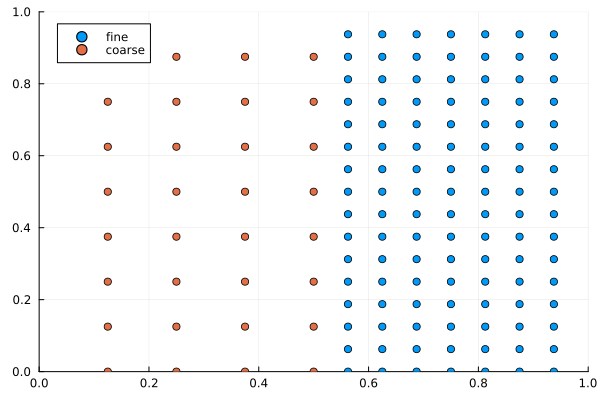

In [18]:
view(m)

In [41]:
# symmetry
Lmat = Matrix(L)
norm(Lmat,Lmat',"inf") == 0.

true

In [42]:
# positive definite
evals = eigen(Lmat).values
maximum(evals) * minimum(evals) > 0

true